##Import libraries

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import numpy as np
import pandas as pd
import os
import random
from PIL import Image, ImageDraw, ImageFont
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import torchvision.models as models

##Change directory

In [38]:
%cd /content/drive/MyDrive/ปี3/เทอม1/ปลายภาค/Computer Vision/miniProject

/content/drive/MyDrive/ปี3/เทอม1/ปลายภาค/Computer Vision/miniProject


In [39]:
%pwd

'/content/drive/MyDrive/ปี3/เทอม1/ปลายภาค/Computer Vision/miniProject'

##Download Dataset

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="RWP0ijumYGd10DQFn13D")
project = rf.workspace("burapha-university-koant").project("ivus-100-f6kgm")
version = project.version(1)
dataset = version.download("tensorflow")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to IVUS-100-1 in tensorflow:: 100%|██████████| 108/108 [00:01<00:00, 80.87it/s]


##Read file

In [ ]:
train = pd.read_csv(r"/content/drive/MyDrive/ปี3/เทอม1/ปลายภาค/Computer Vision/miniProject/IVUS-100-1/train/_annotations.csv")
test = pd.read_csv(r"/content/drive/MyDrive/ปี3/เทอม1/ปลายภาค/Computer Vision/miniProject/IVUS-100-1/test/_annotations.csv")

In [ ]:
train.tail()

,filename,width,height,class,xmin,ymin,xmax,ymax
65,frame_01_0003_001_png.rf.f34656efbd854ec9de462...,384,384,Lumen,91,90,289,259
66,frame_01_0018_003_png.rf.f45dd6d83bdb0f31faa90...,384,384,Lumen,65,73,266,266
67,frame_01_0020_002_png.rf.c60dd77cc6a3f78aa24fc...,384,384,Lumen,82,92,262,272
68,frame_01_0007_001_png.rf.f380b7609c32de7587fd8...,384,384,Lumen,94,75,268,253
69,frame_01_0009_003_png.rf.fcd42336738778e35badc...,384,384,Lumen,95,64,273,248


In [ ]:
unique_imgs = train.filename.unique()
unique_imgs

array(['frame_01_0011_005_png.rf.118ded0456e633c1c5b5ef9f3f28a2ef.jpg',
       'frame_01_0002_005_png.rf.111ac9f64ff24ab86118b4f128babbda.jpg',
       'frame_01_0008_001_png.rf.169bd798158d131c5ad134f9c3eb2cd5.jpg',
       'frame_01_0016_003_png.rf.391e0ae668d6dedfb6a0529ab9b731a2.jpg',
       'frame_01_0001_005_png.rf.15d2645e2ffb10b07d1fb0ac74b41c57.jpg',
       'frame_01_0002_001_png.rf.3a2748071275f700552f46c19bf2acbd.jpg',
       'frame_01_0012_001_png.rf.22583b2bbc3b655a8268425a114b4921.jpg',
       'frame_01_0013_003_png.rf.2f091fd5e3753e8bc6fdc5ed048c31e4.jpg',
       'frame_01_0006_001_png.rf.22029b0ca0984b5f8707168a2b6c192c.jpg',
       'frame_01_0005_002_png.rf.2a05ac9d8d28f4f7887acef23434b3ce.jpg',
       'frame_01_0002_002_png.rf.61c0be3a569f73ef24be160f996b07c4.jpg',
       'frame_01_0010_005_png.rf.08af459287ef810c3d8f32ad4042833e.jpg',
       'frame_01_0007_005_png.rf.6518466d367ff72010338de13cfc6f06.jpg',
       'frame_01_0002_003_png.rf.36d4a79725b17b805e310b4235315de

##Prepocessing

In [ ]:
# class สำหรับแก้ไข training Dataset
import torch.utils
class CustDat(torch.utils.data.Dataset):
    def __init__(self, df, unique_imgs, indices):
        self.df = df
        self.unique_imgs = unique_imgs
        self.indices = indices
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        image_name = self.unique_imgs[self.indices[idx]]
        boxes = self.df[self.df.filename == image_name].values[:, 4:].astype("float")
        img = Image.open(r"/content/drive/MyDrive/ปี3/เทอม1/ปลายภาค/Computer Vision/miniProject/IVUS-100-1/train/"+image_name)
        labels = torch.ones((boxes.shape[0]), dtype=torch.int64)
        target = {}
        target['boxes'] = torch.tensor(boxes)
        target['label'] = labels
        return T.ToTensor()(img) , target

In [ ]:
# สร้าง training index ของรูป
train_inds = [i for i in range(70)]

In [ ]:
print(type(train_inds))
print(train_inds)

<class 'list'>
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]


In [ ]:
def custom_collate(data):
    return data

In [ ]:
# แก้ Structure ของ training ให้เป็น DataLoader
train_dl = torch.utils.data.DataLoader(CustDat(train, unique_imgs, train_inds),
                                       batch_size = 16,
                                       shuffle = True,
                                       collate_fn = custom_collate,
                                       pin_memory = True if torch.cuda.is_available() else False
                                       )

In [ ]:
# Download Faster R-CNN model สำหรับรูปจาก pytorch
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
#Use GPU for run the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
# Optimizer model && Hyperparameters
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
num_epochs = 10

In [ ]:
# Clear GPU memory **option**
import torch
torch.cuda.empty_cache()

##Training Model

In [ ]:
model.to(device)
for epochs in range(num_epochs):
    epoch_loss = 0
    for data in train_dl:
        imgs = []
        targets = []
        for d in data:
            imgs.append(d[0].to(device))
            targ = {}
            targ["boxes"] = d[1]["boxes"].to(device)
            targ["labels"] = d[1]["label"].to(device)
            targets.append(targ)
        loss_dict = model(imgs, targets)
        loss = sum(v for v in loss_dict.values())
        epoch_loss += loss.cpu().detach().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(epoch_loss)

2.999097500494542
2.102051242145739
1.6458846576325825
1.3117510715077225
1.2097024945449089
1.1273346711110563
1.0331539649011663
1.0001309185635883
0.9665094526765274
0.8824854829799872


In [ ]:
print(test.shape)

(10, 8)


In [ ]:
# class สำหรับแก้ไข testing Dataset
import torch.utils

class CustDat_test(torch.utils.data.Dataset):
    def __init__(self, df, unique_imgs, indices):
        self.df = df
        self.unique_imgs = unique_imgs
        self.indices = indices
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        image_name = self.unique_imgs[self.indices[idx]]
        boxes = self.df[self.df.filename == image_name].values[:, 4:].astype("float")
        img = Image.open(r"/content/drive/MyDrive/ปี3/เทอม1/ปลายภาค/Computer Vision/miniProject/IVUS-100-1/test/"+image_name)
        labels = torch.ones((boxes.shape[0]), dtype=torch.int64)
        target = {}
        target['boxes'] = torch.tensor(boxes)
        target['label'] = labels
        return T.ToTensor()(img) , target

In [ ]:
unique_imgs_test = test.filename.unique()
unique_imgs_test

array(['frame_01_0017_002_png.rf.22f2e622b024dfb43dea54c50a0b128a.jpg',
       'frame_01_0005_005_png.rf.79174776f41ba3eea890a85e4f284cd1.jpg',
       'frame_01_0009_002_png.rf.e85223f58f24d4309124c597ef218a0e.jpg',
       'frame_01_0012_002_png.rf.5b6083e6192c1858973ac6ffa66d1d62.jpg',
       'frame_01_0001_004_png.rf.2688adeaf3c8afae3904d39e92a08426.jpg',
       'frame_01_0001_003_png.rf.075637138556500b9fb8bcbd5aad74f6.jpg',
       'frame_01_0001_001_png.rf.8eb7d7b265fb492a66525abd86087607.jpg',
       'frame_01_0020_003_png.rf.167c1386713db04732c5afaa02969800.jpg',
       'frame_01_0014_003_png.rf.da63485cdbadd13e21f7c9dc35a6d816.jpg',
       'frame_01_0007_003_png.rf.ff834c25207f362872e59b9abee19925.jpg'],
      dtype=object)

In [ ]:
test_inds = [i for i in range(10)]
print(test_inds)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
# แก้ Structure ของ testing ให้เป็น DataLoader
test_dl = torch.utils.data.DataLoader(CustDat_test(test, unique_imgs_test, test_inds),
                                       batch_size = 8,
                                       shuffle = True,
                                       collate_fn = custom_collate,
                                       pin_memory = True if torch.cuda.is_available() else False
                                       )

##Prediction

In [ ]:
model.eval()
data = iter(test_dl).__next__()

In [ ]:
# select a image
img = data[2][0]
boxes = data[0][1]["boxes"]
labels = data[0][1]["label"]

In [ ]:
# model detection
output = model([img.to(device)])

In [ ]:
output

[{'boxes': tensor([[101.0271,  57.4246, 294.8426, 268.2424],
          [129.7106,  85.0976, 261.3549, 237.7157],
          [ 37.2338,  71.5469, 342.5963, 369.5828],
          [ 93.0223, 105.4038, 353.2232, 229.6098],
          [ 75.4829,  40.6867, 209.6595, 266.3072],
          [161.1097,  22.9267, 343.8934, 301.6212],
          [105.7275,  41.5431, 295.2768, 172.3206],
          [ 17.2123,  64.9163, 237.1392, 298.7352],
          [ 58.4817, 144.5167, 304.9276, 253.2975]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9320, 0.6315, 0.4886, 0.3433, 0.2517, 0.1162, 0.1047, 0.0920, 0.0633],
         device='cuda:0', grad_fn=<IndexBackward0>)}]

In [ ]:
out_bbox = output[0]["boxes"]
out_scores = output[0]["scores"]

In [ ]:
keep = torchvision.ops.nms(out_bbox, out_scores, 0.45)

In [ ]:
out_bbox.shape, keep.shape

(torch.Size([9, 4]), torch.Size([3]))

In [ ]:
im = (img.permute(1, 2, 0).cpu().detach().numpy() * 255).astype('uint8')

##Visualization

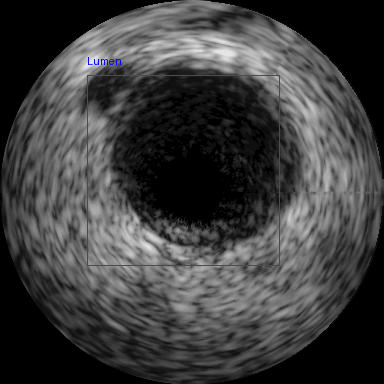

In [ ]:
vsample = Image.fromarray(im)
draw = ImageDraw.Draw(vsample)
for box in boxes:
    draw.rectangle(list(box), fill = None, outline = 'red')
    text_position = (box[0], box[1] - 20)
    draw.text(text_position, 'Lumen', fill='blue')
vsample

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-17-b14c8266b3ec>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

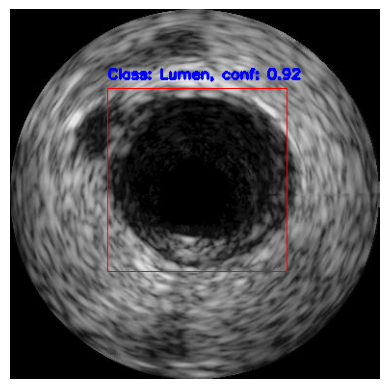

In [ ]:
# โหลดโมเดล Faster R-CNN
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = 2  # 1 คลาส + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# โหลด weights เข้าไปในโมเดล
model_path = r'/content/drive/MyDrive/ปี3/เทอม1/ปลายภาค/Computer Vision/miniProject/Faster_R-CNN.pt'  # เปลี่ยนเป็น path ของไฟล์โมเดล
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))) #use cpu
model.eval()  # ตั้งค่าโมเดลให้เป็นโหมด eval

# ฟังก์ชันสำหรับการเตรียมรูปภาพ
def transform_image(image):
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize((384, 384)),  # ปรับขนาดให้เข้ากับโมเดล
        T.ToTensor(),
    ])
    return transform(image).unsqueeze(0)  # เพิ่มมิติ batch

# อ่านรูปภาพ
img_path = r'/content/drive/MyDrive/ปี3/เทอม1/ปลายภาค/Computer Vision/miniProject/IVUS-100-1/test/frame_01_0001_004_png.rf.2688adeaf3c8afae3904d39e92a08426.jpg'  # เปลี่ยนเป็น path ของรูปภาพที่ต้องการตรวจจับ
image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # เปลี่ยนสีจาก BGR เป็น RGB

# เตรียมรูปภาพ
input_tensor = transform_image(image_rgb)

# ทำการตรวจจับวัตถุ
with torch.no_grad():
    predictions = model(input_tensor)

# แสดงผลลัพธ์
boxes = predictions[0]['boxes'].cpu().numpy()
scores = predictions[0]['scores'].cpu().numpy()
labels = predictions[0]['labels'].cpu().numpy()

# วาด bounding boxes บนรูปภาพ
for box, score, label in zip(boxes, scores, labels):
    if score > 0.7:  # กำหนด threshold สำหรับการแสดง bounding box
        x1, y1, x2, y2 = box.astype(int)
        label = "Lumen" if label == 1 else "None"
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 1)  # วาดกรอบ
        cv2.putText(image, f'Class: {label}, conf: {score:.2f}', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

# แสดงผลลัพธ์
plt.imshow(image)
plt.axis('off')  # ปิดแกน
plt.show()

##Export model

In [ ]:
torch.save(model.state_dict(), "Faster_R-CNN.pt")

##Evaluation model

In [ ]:
import os

# โหลดโมเดล Faster R-CNN
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = 2  # 1 คลาส + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# โหลด weights เข้าไปในโมเดล
model_path = r'/content/drive/MyDrive/ปี3/เทอม1/ปลายภาค/Computer Vision/miniProject/Faster_R-CNN.pt'  # เปลี่ยนเป็น path ของไฟล์โมเดล
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))) #use cpu
model.eval()  # ตั้งค่าโมเดลให้เป็นโหมด eval

data = {'filename': [],
        'class': [],
        'confidence': [],
        'xmin': [],
        'ymin': [],
        'xmax': [],
        'ymax': []
        }
pred_df = pd.DataFrame(data)

# ฟังก์ชันสำหรับการเตรียมรูปภาพ
def transform_image(image):
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize((384, 384)),  # ปรับขนาดให้เข้ากับโมเดล
        T.ToTensor(),
    ])
    return transform(image).unsqueeze(0)  # เพิ่มมิติ batch

# ฟังก์ชันสำหรับการตรวจจับวัตถุในรูปภาพ
def detect_objects(image_path, filename):
    global pred_df
    # อ่านรูปภาพ
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # เปลี่ยนสีจาก BGR เป็น RGB

    # เตรียมรูปภาพ
    input_tensor = transform_image(image_rgb)

    # ทำการตรวจจับวัตถุ
    with torch.no_grad():
        predictions = model(input_tensor)

    # แสดงผลลัพธ์
    boxes = predictions[0]['boxes'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()

    # วาด bounding boxes บนรูปภาพ
    for box, score, label in zip(boxes, scores, labels):
        if score > 0.7:  # กำหนด threshold สำหรับการแสดง bounding box
            x1, y1, x2, y2 = box.astype(int)
            label = "Lumen" if label == 1 else "None"
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 1)  # วาดกรอบ
            cv2.putText(image, f'Class: {label}, conf: {score:.2f}', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

            new_data = pd.DataFrame({'filename': [filename],
                        'class': [label],
                        'confidence': [round(score, 2)],
                        'xmin': [x1],
                        'ymin': [y1],
                        'xmax': [x2],
                        'ymax': [y2]})
            # เพิ่มข้อมูลลงใน DataFrame
            pred_df = pd.concat([pred_df, new_data], ignore_index=True)
            print(f'filename: {filename}\nclass: {label}\nconf: {score:.2f}\nxmin: {x1}\nymin: {y1}\nxmax: {x2}\nymax: {y2}\n')

    # แสดงผลลัพธ์
    # plt.imshow(image)
    # plt.axis('off')  # ปิดแกน
    # plt.show()

# ระบุโฟลเดอร์ที่มีรูปภาพ
folder_path = r'/content/drive/MyDrive/ปี3/เทอม1/ปลายภาค/Computer Vision/miniProject/IVUS-100-1/test/'

# ตรวจสอบว่ามีไฟล์ในโฟลเดอร์หรือไม่
if os.path.exists(folder_path):
    # วนลูปผ่านไฟล์ภาพในโฟลเดอร์
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):  # ตรวจสอบนามสกุลไฟล์
            image_path = os.path.join(folder_path, filename)
            detect_objects(image_path, filename)  # เรียกฟังก์ชันตรวจจับวัตถุ
    # pred_df.to_csv('predictions.csv', index=False) # export csv file
else:
    print("โฟลเดอร์ไม่ถูกต้องหรือไม่มีไฟล์")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-21-f71d00c82422>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

filename: frame_01_0001_001_png.rf.8eb7d7b265fb492a66525abd86087607.jpg
class: Lumen
conf: 0.93
xmin: 100
ymin: 57
xmax: 295
ymax: 268

filename: frame_01_0001_003_png.rf.075637138556500b9fb8bcbd5aad74f6.jpg
class: Lumen
conf: 0.93
xmin: 76
ymin: 93
xmax: 298
ymax: 255

filename: frame_01_0001_004_png.rf.2688adeaf3c8afae3904d39e92a08426.jpg
class: Lumen
conf: 0.92
xmin: 101
ymin: 82
xmax: 287
ymax: 272

filename: frame_01_0005_005_png.rf.79174776f41ba3eea890a85e4f284cd1.jpg
class: Lumen
conf: 0.94
xmin: 83
ymin: 66
xmax: 280
ymax: 260

filename: frame_01_0007_003_png.rf.ff834c25207f362872e59b9abee19925.jpg
class: Lumen
conf: 0.95
xmin: 87
ymin: 65
xmax: 271
ymax: 260

filename: frame_01_0009_002_png.rf.e85223f58f24d4309124c597ef218a0e.jpg
class: Lumen
conf: 0.95
xmin: 90
ymin: 60
xmax: 268
ymax: 259

filename: frame_01_0012_002_png.rf.5b6083e6192c1858973ac6ffa66d1d62.jpg
class: Lumen
conf: 0.93
xmin: 93
ymin: 71
xmax: 276
ymax: 262

filename: frame_01_0014_003_png.rf.da63485cdbadd13e21

In [40]:
gt_df = pd.read_csv('/content/drive/MyDrive/ปี3/เทอม1/ปลายภาค/Computer Vision/miniProject/IVUS-100-1/test/_annotations.csv')
pred_df = pd.read_csv('/content/drive/MyDrive/ปี3/เทอม1/ปลายภาค/Computer Vision/miniProject/predictions.csv')

In [44]:
def compute_iou(box1, box2):
    x_min1, y_min1, x_max1, y_max1 = box1
    x_min2, y_min2, x_max2, y_max2 = box2

    # Find the intersection box
    inter_x_min = max(x_min1, x_min2)
    inter_y_min = max(y_min1, y_min2)
    inter_x_max = min(x_max1, x_max2)
    inter_y_max = min(y_max1, y_max2)

    # Compute area of intersection
    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)

    # Compute areas of both boxes
    box1_area = (x_max1 - x_min1) * (y_max1 - y_min1)
    box2_area = (x_max2 - x_min2) * (y_max2 - y_min2)

    # Compute union area
    union_area = box1_area + box2_area - inter_area

    # Compute IoU
    IoU = inter_area / union_area
    print(IoU)
    return IoU

def match_predictions_to_gt(pred_df, gt_df, iou_threshold=0.5):
    results = []

    # Iterate over each predicted box
    for _, pred in pred_df.iterrows():
        pred_box = [pred['xmin'], pred['ymin'], pred['xmax'], pred['ymax']]
        image_id = pred['filename']
        pred_class = pred['class']
        max_iou = 0
        matched_gt = None

        # Filter ground truth boxes for the same image and class
        gt_for_image = gt_df[(gt_df['filename'] == image_id) & (gt_df['class'] == pred_class)]

        # Find the best matching ground truth box
        for _, gt in gt_for_image.iterrows():
            gt_box = [gt['xmin'], gt['ymin'], gt['xmax'], gt['ymax']]
            iou = compute_iou(pred_box, gt_box)
            if iou > max_iou:
                max_iou = iou
                matched_gt = gt

        # Check if IoU exceeds the threshold (True Positive)
        if max_iou >= iou_threshold:
            results.append((pred['confidence'], 1))  # True Positive
            gt_df = gt_df.drop(matched_gt.name)  # Remove the matched ground truth
        else:
            results.append((pred['confidence'], 0))  # False Positive

    return results

def compute_precision_recall(results):
    # Sort by confidence score
    results = sorted(results, key=lambda x: x[0], reverse=True)

    tp = 0
    fp = 0
    precisions = []
    recalls = []

    total_gt = len(gt_df)

    # Calculate Precision and Recall at each threshold
    for conf, is_tp in results:
        if is_tp:
            tp += 1
        else:
            fp += 1

        precision = tp / (tp + fp)
        recall = tp / total_gt

        precisions.append(precision)
        recalls.append(recall)

    return precisions, recalls

def compute_ap(precisions, recalls):
    # Interpolated AP calculation
    ap = 0.0
    for t in range(0, 11):
        threshold = t / 10.0
        p = max([p for r, p in zip(recalls, precisions) if r >= threshold], default=0)
        ap += p / 11.0
    return ap

In [45]:
# Get matched results
results = match_predictions_to_gt(pred_df, gt_df)

# Calculate Precision and Recall
precisions, recalls = compute_precision_recall(results)

# Calculate AP
ap = compute_ap(precisions, recalls)

# Print AP for the class
print(f'Average Precision (AP): {ap}')
print(f'Precision: {precisions}')
print(f'Recall: {recalls}')

0.7357394580143395
0.7815299793246038
0.8457671592321503
0.8821179302045729
0.8536776015532413
0.8798910142973512
0.9196227023540793
0.7035405111191747
0.8374277086851937
0.6505765923252601
Average Precision (AP): 1.0000000000000002
Precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recall: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


In [43]:
def compute_map(gt_df, pred_df):
    classes = gt_df['class'].unique()
    ap_total = 0

    for cls in classes:
        # Filter by class
        gt_class_df = gt_df[gt_df['class'] == cls]
        pred_class_df = pred_df[pred_df['class'] == cls]

        # Match predictions and compute AP
        results = match_predictions_to_gt(pred_class_df, gt_class_df)
        precisions, recalls = compute_precision_recall(results)
        ap = compute_ap(precisions, recalls)

        ap_total += ap

    # mAP is the average of APs across all classes
    mAP = ap_total / len(classes)
    print(f'mAP: {mAP}')
    return mAP

# Calculate mAP
compute_map(gt_df, pred_df)


mAP: 1.0000000000000002


1.0000000000000002

In [46]:
print('mean IoU:', np.mean([0.7357394580143395,
                            0.7815299793246038,
                            0.8457671592321503,
                            0.8821179302045729,
                            0.8536776015532413,
                            0.8798910142973512,
                            0.9196227023540793,
                            0.7035405111191747,
                            0.8374277086851937,
                            0.6505765923252601]))

mean IoU: 0.8089890657109967
